In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#import machine learning package
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn import linear_model, metrics
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

In [4]:
sales_item = pd.read_csv('../data/items.csv')
sales_item_category = pd.read_csv('../data/item_categories.csv')
sales_shops = pd.read_csv('../data/shops.csv')
sales_test = pd.read_csv('../data/test.csv')

In [5]:
sales_train = pd.read_csv('../data/sales_train.csv', parse_dates=['date'], dtype={'date':'str', 'date_block_num':'int64', 'shop_id':'int64','item_id':'int64','item_price':'float64','item_cnt_day':'int64'})
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,22154,999.00,1
1,2013-03-01,0,25,2552,899.00,1
2,2013-05-01,0,25,2552,899.00,-1
3,2013-06-01,0,25,2554,1709.05,1
4,2013-01-15,0,25,2555,1099.00,1


In [6]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.4 MB


In [7]:
print(sales_item.shape)
print(sales_item_category.shape)
print(sales_shops.shape)
print(sales_train.shape)
print(sales_test.shape)

(22170, 3)
(84, 2)
(60, 2)
(2935849, 6)
(214200, 3)


In [8]:
#checking null value
print('----Item----\n', sales_item.isnull().sum())
print('----Item Category----\n', sales_item_category.isnull().sum())
print('----Shops----\n', sales_shops.isnull().sum())
print('----Train----\n', sales_train.isnull().sum())
print('----Test----\n', sales_test.isnull().sum())

----Item----
 item_name           0
item_id             0
item_category_id    0
dtype: int64
----Item Category----
 item_category_name    0
item_category_id      0
dtype: int64
----Shops----
 shop_name    0
shop_id      0
dtype: int64
----Train----
 date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
----Test----
 ID         0
shop_id    0
item_id    0
dtype: int64


In [9]:
#check duplicate
sales_train[sales_train.duplicated()]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
76962,2013-05-01,0,54,20130,149.0,1
1435367,2014-02-23,13,50,3423,999.0,1
1496766,2014-03-23,14,21,3423,999.0,1
1671873,2014-01-05,16,50,3423,999.0,1
1866340,2014-12-07,18,25,3423,999.0,1
2198566,2014-12-31,23,42,21619,499.0,1


In [10]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         int64         
 3   item_id         int64         
 4   item_price      float64       
 5   item_cnt_day    int64         
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 134.4 MB


In [11]:
sales_train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


In [12]:
sales_dataset = sales_train.copy()

In [13]:
sales_dataset[sales_dataset['item_cnt_day']==2169]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2909818,2015-10-28,33,12,11373,0.908714,2169


In [14]:
sales_monthly = sales_dataset.groupby(['date_block_num','shop_id','item_id'])['date','item_price','item_cnt_day'].agg({'item_price':'mean','item_cnt_day':'sum'})

In [15]:
sales_monthly.head()

item_price  item_cnt_day
date_block_num shop_id item_id                          
0              0       32            221.0             6
                       33            347.0             3
                       35            247.0             1
                       43            221.0             1
                       51            128.5             2

<AxesSubplot:xlabel='date_block_num'>

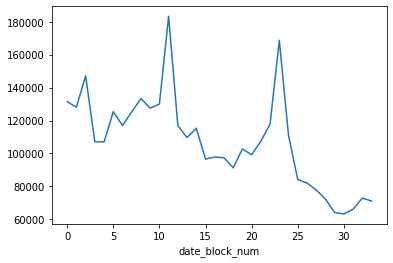

In [16]:
monthly_sales = sales_dataset.groupby(['date_block_num'])['item_cnt_day'].sum()
monthly_sales.plot()

<AxesSubplot:>

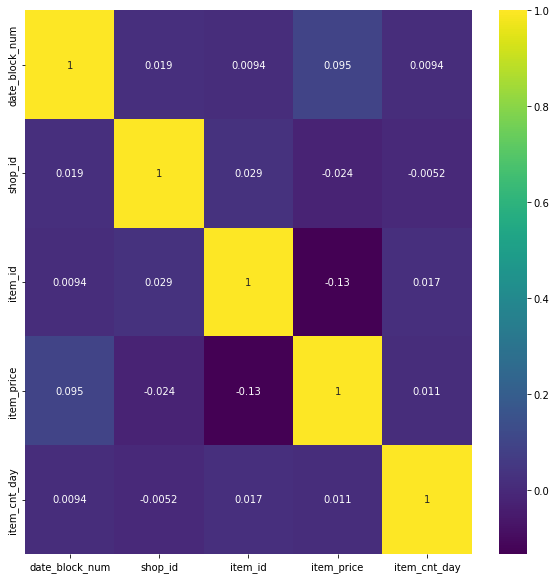

In [17]:
plt.figure(figsize = (10,10))

sns.heatmap(sales_dataset.corr(), cmap = 'viridis', annot = True)

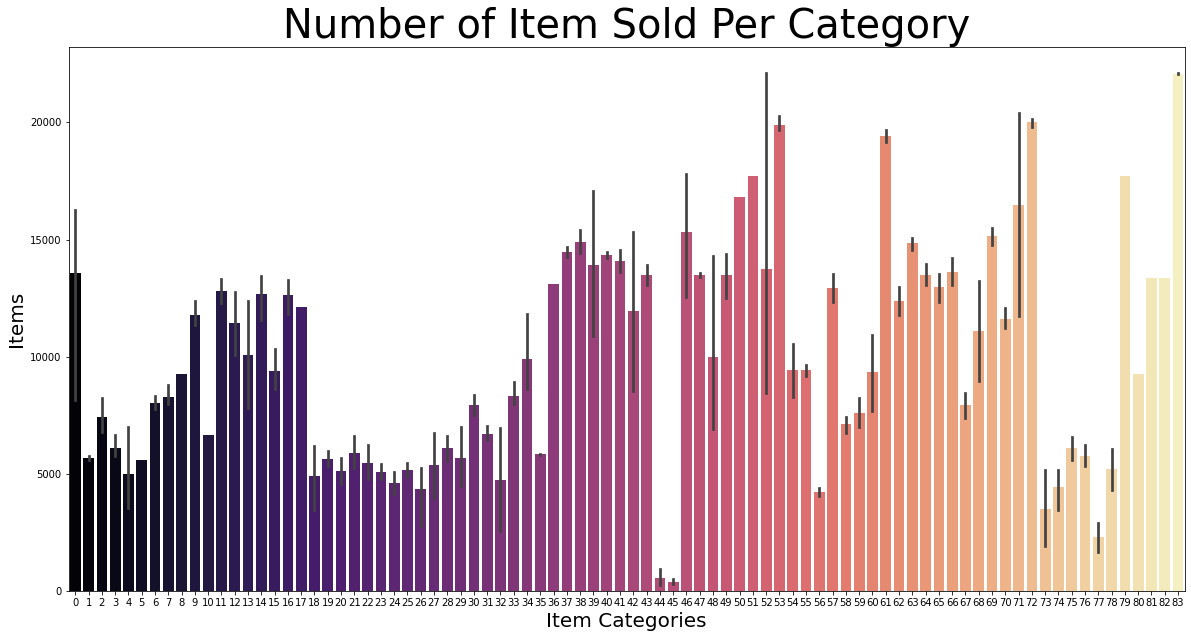

In [18]:
plt.figure(figsize = (20,10))
sns.barplot(sales_item['item_category_id'],sales_item['item_id'],palette='magma')
plt.title('Number of Item Sold Per Category', fontsize = 40)
plt.xlabel('Item Categories', fontsize = 20)
plt.ylabel('Items', fontsize = 20)
plt.show()

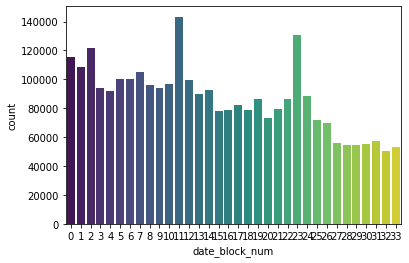

In [19]:
sns.countplot(sales_dataset['date_block_num'],palette='viridis')
plt.show()

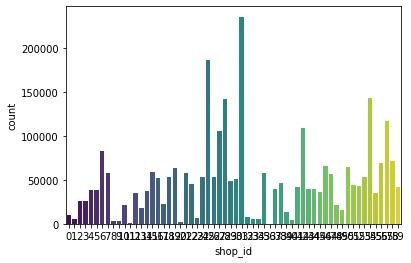

In [20]:
sns.countplot(sales_dataset['shop_id'],palette='viridis')
plt.show()

In [21]:
## Creating Date , Month and Year 

days = []
months = []
years = []

for day in sales_dataset['date']:
    days.append(day.day)
for month in sales_dataset['date']:
    months.append(month.month)
for year in sales_dataset['date']:
    years.append(year.year)

In [22]:
sales_dataset['day'] = days
sales_dataset['month'] = months
sales_dataset['year'] = years

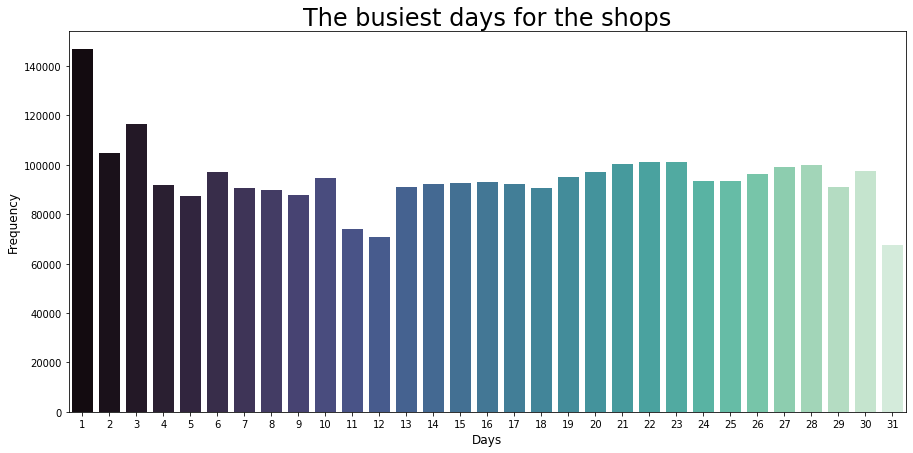

In [23]:
plt.figure(figsize = (15,7))
sns.countplot(days, palette= 'mako')
plt.title('The busiest days for the shops', fontsize = 24)
plt.xlabel('Days', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

Text(0, 0.5, 'Frequency')

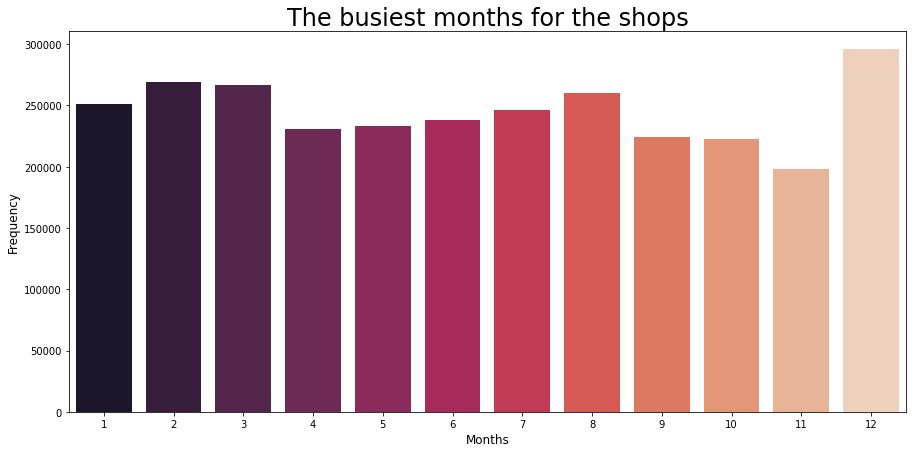

In [24]:
plt.figure(figsize = (15,7))
sns.countplot(months, palette= 'rocket')
plt.title('The busiest months for the shops', fontsize = 24)
plt.xlabel('Months', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

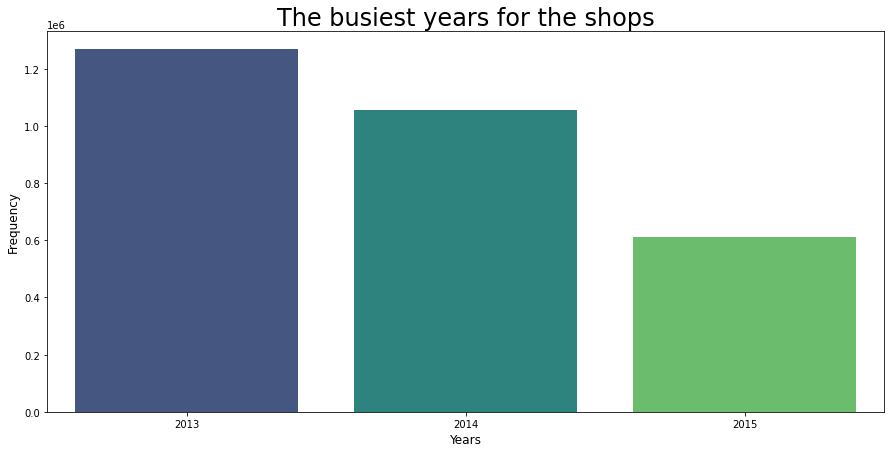

In [25]:
plt.rcParams['figure.figsize'] = (15, 7)
sns.countplot(years, palette= 'viridis')
plt.title('The busiest years for the shops', fontsize = 24)
plt.xlabel('Years', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)

plt.show()

In [26]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1,1,2,2013
1,2013-03-01,0,25,2552,899.00,1,1,3,2013
2,2013-05-01,0,25,2552,899.00,-1,1,5,2013
3,2013-06-01,0,25,2554,1709.05,1,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1,15,1,2013


<AxesSubplot:xlabel='shop_id', ylabel='count'>

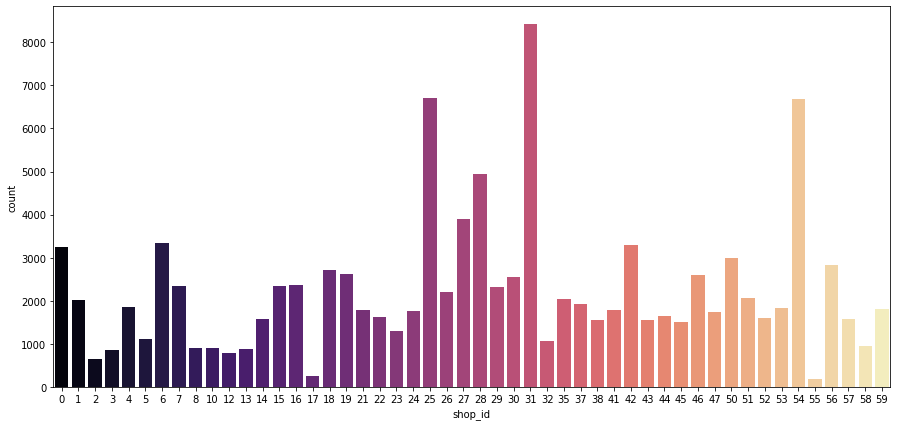

In [27]:
sns.countplot(sales_dataset[(sales_dataset.month == 2) & (sales_dataset.year == 2013)]['shop_id'], palette='magma')

In [30]:
sales_dataset.shape

(2935849, 9)

In [28]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1,1,2,2013
1,2013-03-01,0,25,2552,899.00,1,1,3,2013
2,2013-05-01,0,25,2552,899.00,-1,1,5,2013
3,2013-06-01,0,25,2554,1709.05,1,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1,15,1,2013


In [31]:
sales_dataset = sales_dataset[sales_dataset['item_price'] < 100000]
sales_dataset = sales_dataset[sales_dataset['item_cnt_day'] < 1200]

In [32]:
sales_dataset.shape

(2935847, 9)

In [33]:
sales_dataset[sales_dataset['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
484683,2013-05-15,4,32,2973,-1.0,1,15,5,2013


In [38]:
sales_median = sales_dataset[(sales_dataset.shop_id==32)&(sales_dataset.item_id==2973)&(sales_dataset.date_block_num==4)&(sales_dataset.item_price>0)].item_price.median()
sales_median

1874.0

In [39]:
sales_dataset['item_price'] = sales_dataset['item_price'].map(lambda x : sales_median if x < 0 else x)

In [40]:
sales_dataset[sales_dataset['item_price']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year


In [41]:
sales_dataset[sales_dataset['item_cnt_day'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
2,2013-05-01,0,25,2552,899.0,-1,1,5,2013
148,2013-01-23,0,25,2321,999.0,-1,23,1,2013
175,2013-07-01,0,25,2199,1449.0,-1,1,7,2013
807,2013-02-01,0,25,2330,599.0,-1,1,2,2013
1041,2013-01-13,0,25,5034,1989.0,-1,13,1,2013
...,...,...,...,...,...,...,...,...,...
2934243,2015-10-26,33,25,3917,449.0,-1,26,10,2015
2934462,2015-10-18,33,25,4896,6398.0,-1,18,10,2015
2935263,2015-05-10,33,25,10039,249.0,-1,10,5,2015
2935643,2015-10-16,33,25,7893,2990.0,-1,16,10,2015


In [42]:
sales_dataset['item_cnt_day'] = sales_dataset['item_cnt_day'].map(lambda x : 0 if x<0 else x)

In [43]:
sales_dataset[sales_dataset['item_cnt_day']<0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year


# Data processing

In [44]:
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1,1,2,2013
1,2013-03-01,0,25,2552,899.00,1,1,3,2013
2,2013-05-01,0,25,2552,899.00,0,1,5,2013
3,2013-06-01,0,25,2554,1709.05,1,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1,15,1,2013


In [46]:
#checking the uniqueness in shop and test
print('Unique Item:', sales_item['item_id'].nunique())
print("Unique Item (Train) : ",sales_dataset['item_id'].nunique())
print("Unique Item (Test) : ",sales_test['item_id'].nunique())

Unique Item: 22170
Unique Item (Train) :  21806
Unique Item (Test) :  5100


In [47]:
print("Unique Item : ",sales_shops['shop_id'].nunique())
print("Unique Item (Train) : ",sales_dataset['shop_id'].nunique())
print("Unique Item (Test) : ",sales_test['shop_id'].nunique())

Unique Item :  60
Unique Item (Train) :  60
Unique Item (Test) :  42


In [48]:
test_item_list = [x for x in (np.unique(sales_test['item_id']))]
train_item_list = [x for x in (np.unique(sales_dataset['item_id']))]

missing_item_ids_ = [element for element in test_item_list if element not in train_item_list]
len(missing_item_ids_)

363

In [52]:
sales_shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [59]:
sales_shops['shop_name'] = sales_shops['shop_name'].map(lambda x: x.split('!')[1] if x.startswith('!') else x)

In [60]:
sales_shops['shop_name'] = sales_shops['shop_name'].map(lambda x: 'СергиевПосад ТЦ "7Я"' if x == 'Сергиев Посад ТЦ "7Я"' else x)

In [61]:
sales_shops.head()

,shop_name,shop_id
0,"Якутск Орджоникидзе, 56 фран",0
1,"Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [62]:
sales_shops['shop_city'] = sales_shops['shop_name'].map(lambda x: x.split(" ")[0])
# lets assign code to these city names too
sales_shops['city_code'] = sales_shops['shop_city'].factorize()[0]

In [65]:
for shop_id in sales_shops['shop_id'].unique():
    sales_shops.loc[shop_id,'num_of_product'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_id'].nunique()
    sales_shops.loc[shop_id,'min_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].min()
    sales_shops.loc[shop_id,'max_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].max()
    sales_shops.loc[shop_id,'mean_price'] = sales_dataset[sales_dataset['shop_id']==shop_id]['item_price'].mean()
    
sales_shops.head()

,shop_name,shop_id,shop_city,city_code,num_of_product,min_price,max_price,mean_price
0,"Якутск Орджоникидзе, 56 фран",0,Якутск,0,3600.0,13.0,15653.0,563.444151
1,"Якутск ТЦ ""Центральный"" фран",1,Якутск,0,2523.0,13.0,15653.0,515.350652
2,"Адыгея ТЦ ""Мега""",2,Адыгея,1,4849.0,0.1,34990.0,1350.638391
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха,2,5261.0,0.1,42990.0,1036.840634
4,"Волжский ТЦ ""Волга Молл""",4,Волжский,3,7309.0,0.1,34990.0,923.994318


In [66]:
sales_item_category.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [67]:
category_list =[]

for cat_name in sales_item_category['item_category_name']:
    category_list.append(cat_name.split('-'))

category_list

[['PC ', ' Гарнитуры/Наушники'],
 ['Аксессуары ', ' PS2'],
 ['Аксессуары ', ' PS3'],
 ['Аксессуары ', ' PS4'],
 ['Аксессуары ', ' PSP'],
 ['Аксессуары ', ' PSVita'],
 ['Аксессуары ', ' XBOX 360'],
 ['Аксессуары ', ' XBOX ONE'],
 ['Билеты (Цифра)'],
 ['Доставка товара'],
 ['Игровые консоли ', ' PS2'],
 ['Игровые консоли ', ' PS3'],
 ['Игровые консоли ', ' PS4'],
 ['Игровые консоли ', ' PSP'],
 ['Игровые консоли ', ' PSVita'],
 ['Игровые консоли ', ' XBOX 360'],
 ['Игровые консоли ', ' XBOX ONE'],
 ['Игровые консоли ', ' Прочие'],
 ['Игры ', ' PS2'],
 ['Игры ', ' PS3'],
 ['Игры ', ' PS4'],
 ['Игры ', ' PSP'],
 ['Игры ', ' PSVita'],
 ['Игры ', ' XBOX 360'],
 ['Игры ', ' XBOX ONE'],
 ['Игры ', ' Аксессуары для игр'],
 ['Игры Android ', ' Цифра'],
 ['Игры MAC ', ' Цифра'],
 ['Игры PC ', ' Дополнительные издания'],
 ['Игры PC ', ' Коллекционные издания'],
 ['Игры PC ', ' Стандартные издания'],
 ['Игры PC ', ' Цифра'],
 ['Карты оплаты (Кино, Музыка, Игры)'],
 ['Карты оплаты ', ' Live!'],
 ['К

In [68]:
sales_item_category['split'] = (category_list)
sales_item_category['category_type'] = sales_item_category['split'].map(lambda x: x[0])

In [70]:
sales_item_category['category_type_code'] = sales_item_category['category_type'].factorize()[0]

In [71]:
sales_item_category['sub_category_type'] = sales_item_category['split'].map(lambda x: x[1] if len(x)>1 else x[0])

sales_item_category['sub_category_type_code'] = sales_item_category['sub_category_type'].factorize()[0]

In [72]:
sales_item_category.drop('split',axis = 1 ,inplace = True)

sales_item_category.head()

,item_category_name,item_category_id,category_type,category_type_code,sub_category_type,sub_category_type_code
0,PC - Гарнитуры/Наушники,0,PC,0,Гарнитуры/Наушники,0
1,Аксессуары - PS2,1,Аксессуары,1,PS2,1
2,Аксессуары - PS3,2,Аксессуары,1,PS3,2
3,Аксессуары - PS4,3,Аксессуары,1,PS4,3
4,Аксессуары - PSP,4,Аксессуары,1,PSP,4


In [73]:
sales_dataset = sales_dataset[sales_dataset['item_cnt_day']>0]
sales_dataset.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,day,month,year
0,2013-02-01,0,59,22154,999.00,1,1,2,2013
1,2013-03-01,0,25,2552,899.00,1,1,3,2013
3,2013-06-01,0,25,2554,1709.05,1,1,6,2013
4,2013-01-15,0,25,2555,1099.00,1,15,1,2013
5,2013-10-01,0,25,2564,349.00,1,1,10,2013


In [77]:
sales_dataset = sales_dataset[["month", "date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day"]].groupby(['date_block_num',"shop_id", "item_id"]).agg({"item_price":"mean","item_cnt_day":"sum","month":"min"}).reset_index()

In [76]:
sales_dataset.head(10)

,date_block_num,shop_id,item_id,item_price,item_cnt_day,month
0,0,0,32,221.0,6,1
1,0,0,33,347.0,3,1
2,0,0,35,247.0,1,1
3,0,0,43,221.0,1,1
4,0,0,51,128.5,2,1
5,0,0,61,195.0,1,10
6,0,0,75,76.0,1,1
7,0,0,88,76.0,1,1
8,0,0,95,193.0,1,6
9,0,0,96,70.0,1,10


In [78]:
sales_dataset.rename(columns={"item_cnt_day":"item_cnt_month"},inplace=True)

In [79]:
sales_dataset.head(2)

,date_block_num,shop_id,item_id,item_price,item_cnt_month,month
0,0,0,32,221.0,6,1
1,0,0,33,347.0,3,1


In [80]:
# merging item , shops and category

sales_dataset = pd.merge(sales_dataset,sales_item,on='item_id',how='inner')

sales_dataset = pd.merge(sales_dataset,sales_shops,on='shop_id',how='inner')

sales_dataset = pd.merge(sales_dataset,sales_item_category,on='item_category_id',how='inner')

In [81]:
sales_dataset.head(2).T

,0,1
date_block_num,0,1
shop_id,0,0
item_id,32,32
item_price,221.0,221.0
item_cnt_month,6,10
month,1,2
item_name,1+1,1+1
item_category_id,40,40
shop_name,"Якутск Орджоникидзе, 56 фран","Якутск Орджоникидзе, 56 фран"
shop_city,Якутск,Якутск


In [88]:
sales_dataset.drop(['item_name','shop_name','shop_city','item_category_name','category_type','sub_category_type'],axis = 1,inplace=True)

In [83]:
sales_test.head(2)

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320


In [92]:
sales_test.shape

(214200, 3)

In [91]:
sales_dataset.shape

(599912, 14)

In [89]:
sales_dataset = sales_dataset[sales_dataset['shop_id'].isin(sales_test['shop_id'].unique())]
sales_dataset = sales_dataset[sales_dataset['item_id'].isin(sales_test['item_id'].unique())]

In [90]:
sales_dataset.shape

(599912, 14)

In [93]:
sales_dataset.head().T

,2833,2834,2835,2836,2837
date_block_num,0.000000,2.000000,4.000000,7.000000,11.000000
shop_id,3.000000,3.000000,3.000000,3.000000,3.000000
item_id,32.000000,32.000000,32.000000,32.000000,32.000000
item_price,349.000000,349.000000,349.000000,349.000000,149.000000
item_cnt_month,3.000000,2.000000,1.000000,1.000000,1.000000
month,1.000000,2.000000,5.000000,8.000000,12.000000
item_category_id,40.000000,40.000000,40.000000,40.000000,40.000000
city_code,2.000000,2.000000,2.000000,2.000000,2.000000
num_of_product,5261.000000,5261.000000,5261.000000,5261.000000,5261.000000
min_price,0.100000,0.100000,0.100000,0.100000,0.100000


In [94]:
sales_train_new = sales_dataset.copy()

sales_train_new = sales_train_new.pivot_table(index=['item_id','shop_id'], columns = 'date_block_num', values = 'item_cnt_month', fill_value = 0).reset_index()

sales_train_new = pd.merge(sales_test,sales_train_new,on = ['item_id','shop_id'],how = 'left')
sales_train_new.fillna(0,inplace = True)

In [102]:
sales_train_new.head()

,ID,shop_id,item_id,0,1,2,3,4,5,6,...,24,25,26,27,28,29,30,31,32,33
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [96]:
sales_train_new.shape

(214200, 37)

In [103]:
sales_train_new.columns

Index([     'ID', 'shop_id', 'item_id',         0,         1,         2,
               3,         4,         5,         6,         7,         8,
               9,        10,        11,        12,        13,        14,
              15,        16,        17,        18,        19,        20,
              21,        22,        23,        24,        25,        26,
              27,        28,        29,        30,        31,        32,
              33],
      dtype='object')

In [104]:
sales_train_new.isnull().sum()

ID         0
shop_id    0
item_id    0
0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
30         0
31         0
32         0
33         0
dtype: int64

In [105]:
X_train = sales_train_new.drop(33, axis=1)
y_train = sales_train_new[32]

X_valid = sales_train_new.drop(33, axis=1)
y_valid = sales_train_new[32]

# deleting the column so that it can predict the future sales data
X_test = sales_train_new.drop(0, axis=1)
y_test = sales_train_new[33]

In [106]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(214200, 36)
(214200, 36)
(214200,)
(214200,)


In [108]:
y_train

0         1.0
1         0.0
2         3.0
3         0.0
4         0.0
         ... 
214195    0.0
214196    0.0
214197    0.0
214198    0.0
214199    0.0
Name: 32, Length: 214200, dtype: float64

In [109]:
lm = LinearRegression()

In [110]:
lm.fit(X_train, y_train)

LinearRegression()

In [111]:
# Predicting the X train and X test

y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

sales_data_lr_metric = []

# calculating r2 square in Train and Test for Linear Regression
print("R2 Square - Linear Regression")
r2_train_lr = r2_score(y_train, y_pred_train)
print("Train : ",r2_train_lr)
sales_data_lr_metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
print("Test : ",r2_test_lr)
sales_data_lr_metric.append(r2_test_lr)

print('_____________________________________')

#Calculating Residual Sum Of Square (RSS) of Train and Test for Linear Regression

print("Residual Sum Of Square (RSS) - Linear Regression")
rss_train_lr = np.sum(np.square(y_train - y_pred_train))
print("Train : ",rss_train_lr)
sales_data_lr_metric.append(rss_train_lr)

rss_test_lr = np.sum(np.square(y_test - y_pred_test))
print("Test : ",rss_test_lr)
sales_data_lr_metric.append(rss_test_lr)

print('_____________________________________')

# Calculating Mean Squared Error(MSE) of Train and Tes for Linear Regression

print("Mean Squared Error (MSE) - Linear Regression")
mse_train_lr = mean_squared_error(y_train, y_pred_train)
print("Train : ",mse_train_lr)
sales_data_lr_metric.append(mse_train_lr**0.5)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
print("Test : ",mse_test_lr)
sales_data_lr_metric.append(mse_test_lr**0.5)

R2 Square - Linear Regression
Train :  1.0
Test :  1.0
_____________________________________
Residual Sum Of Square (RSS) - Linear Regression
Train :  2.199305756413717e-20
Test :  5.325992690225427e-20
_____________________________________
Mean Squared Error (MSE) - Linear Regression
Train :  1.0267533876814739e-25
Test :  2.486457838573962e-25


In [113]:
rfe = RFE(lm,50)
rfe = rfe.fit(X_train, y_train)

TypeError: RFE.__init__() takes 2 positional arguments but 3 were given